# ПМ3-4. Васильев Никита. Творческое задание.

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировать спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/bike-sharing-demand/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

## Библиотеки

In [1]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

## Загрузка данных

In [2]:
raw_data = pd.read_csv('train.csv', header = 0, sep = ',')

In [3]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Посмотрим на наши признаки:

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Данные чистые, Nanов нет

Посмотрим на корреляцию с целевой переменной:

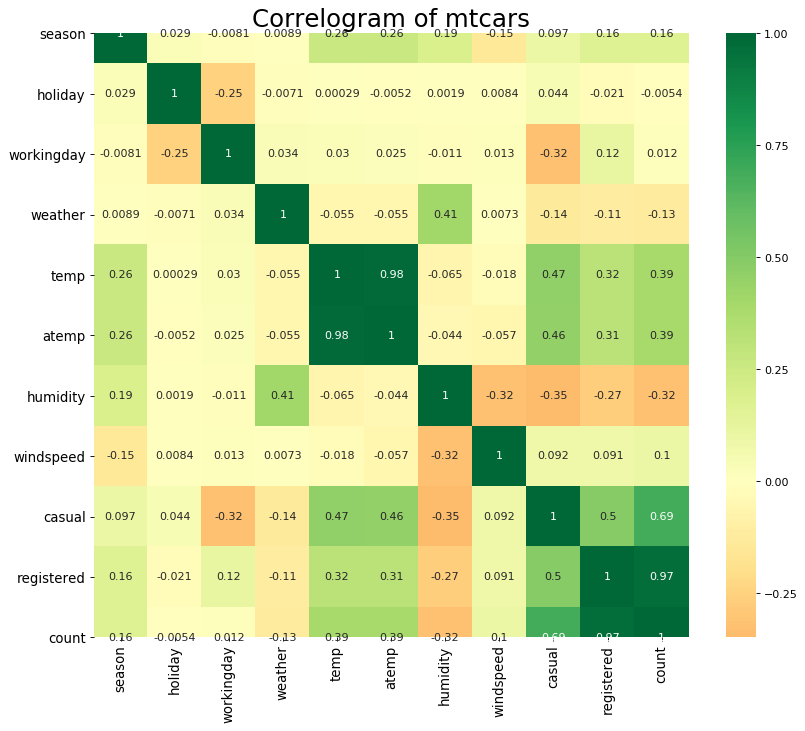

In [5]:
# Plot
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(raw_data.corr(), xticklabels=raw_data.corr().columns, yticklabels=raw_data.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [6]:
raw_data[raw_data.columns[:-1]].corrwith(raw_data['count'])

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
casual        0.690414
registered    0.970948
dtype: float64

Приведём дату к более удобному формату:

In [7]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [8]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['day'] = raw_data.datetime.apply(lambda x: x.day)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [9]:
raw_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,12,19,22


Разделим данные на обучающую и тестовую выборки:

In [10]:
train_data, hold_out_test_data = train_test_split(raw_data, test_size=0.15)

In [11]:
#Обучающая выборка
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered', 'atemp'], axis = 1)

In [12]:
#Тестовая выборка
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered', 'atemp'], axis = 1)

In [13]:
X = train_data.values
y = train_labels
X_test = test_data.values
y_test = test_labels

In [14]:
MSE_History = []

## 1. Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
model = LinearRegression()

In [17]:
model.fit(X, y)  
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [18]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.3372683212427914
mae_train 108.79220439531626
R2_test 0.3321609602078439
mae_test 108.99812529341622


In [19]:
MSE_History.append(['LinearRegression', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

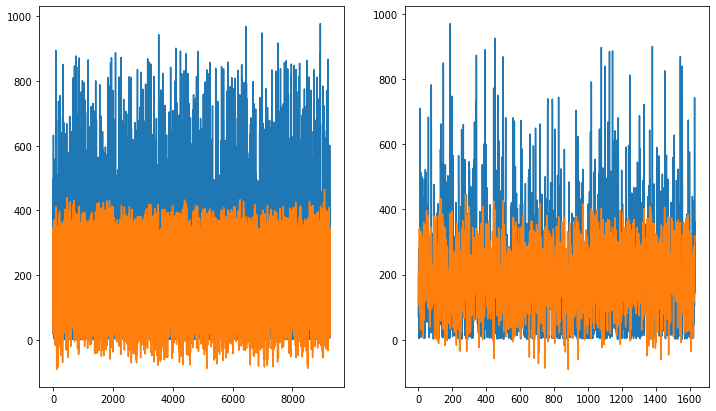

In [20]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

## 2. Linear Regression + Lasso

In [21]:
from sklearn.linear_model import Lasso

In [22]:
model = Lasso()

In [23]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [24]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.3370024638672535
mae_train 108.75209267107897
R2_test 0.3319585674569291
mae_test 108.97600933403555


In [25]:
MSE_History.append(['LinearRegression + Lasso', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

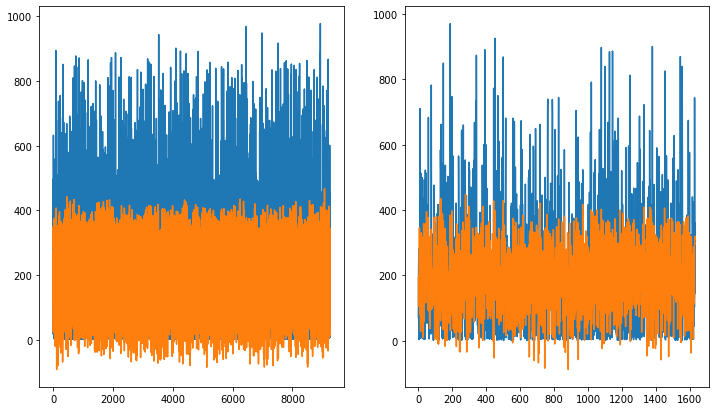

In [26]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

## 3. Linear Regression + Ridge

In [27]:
from sklearn.linear_model import Ridge

In [28]:
model = Ridge()

In [29]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [30]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.3372683203167015
mae_train 108.79212712839555
R2_test 0.33216100570018003
mae_test 108.9980668755114


In [31]:
MSE_History.append(['LinearRegression + Ridge', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

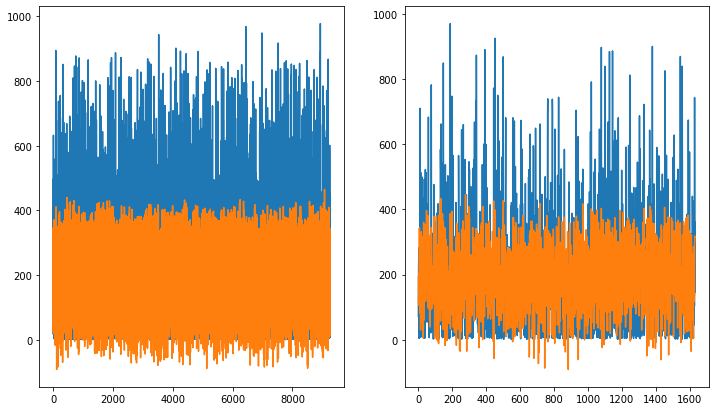

In [32]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

Существенных изменений мы не получаем, т. к. модель не переобучается и без регуляризации

## 4. SVM

In [33]:
from sklearn import svm

In [34]:
model = svm.SVR()

In [35]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

/home/nikita4735/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [36]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train -0.04451854560332724
mae_train 135.8296143115093
R2_test -0.0599579785701867
mae_test 137.27513908840712


In [37]:
MSE_History.append(['SVM', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

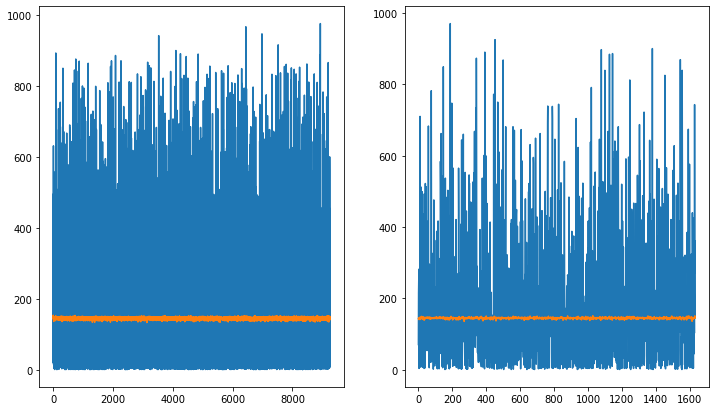

In [38]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

## 5. RandomForest

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
model = RandomForestRegressor(random_state = 0, max_depth = 10, n_estimators = 100)

In [41]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [42]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.8869804718459126
mae_train 40.5317455324376
R2_test 0.8317973604940182
mae_test 50.319165257473344


In [43]:
MSE_History.append(['RandomForest', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

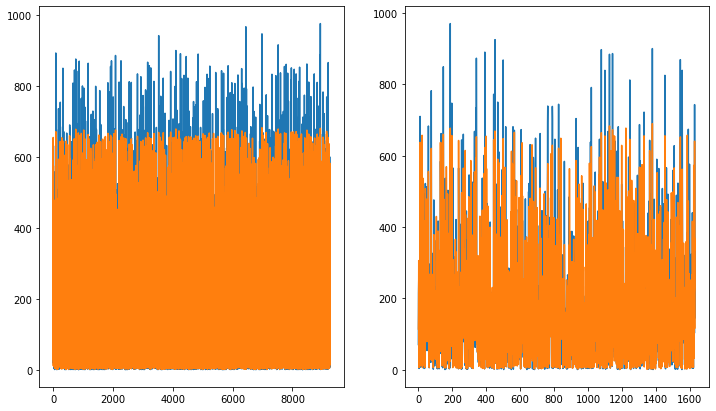

In [44]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

Видим, что случайный лес гораздо лучше выявил паттерны данных, поэтому можно сделать вывод, что зависимость не была линейной

## 6. KNN

In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

Воспользуемся в KNN поиском гиперпараметра K по сетке и кроссвалидацией

In [46]:
param_grid = {
    'n_neighbors': [2,3,4,5,6,7]
}

In [47]:
model = KNeighborsRegressor()

In [48]:
search = GridSearchCV(model, param_grid, cv = 2, scoring = 'r2')

In [49]:
search.fit(X, y)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [50]:
search.best_params_

{'n_neighbors': 7}

In [51]:
model = KNeighborsRegressor(n_neighbors = 7)

In [52]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [53]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.6562724672819094
mae_train 73.19277145636164
R2_test 0.5290625178571862
mae_test 87.26191934213979


In [54]:
MSE_History.append(['KNN', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

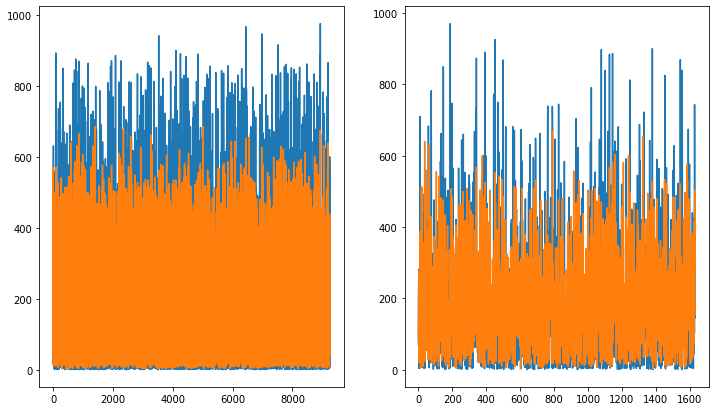

In [55]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

## 7. XGBoost

In [56]:
import xgboost as xgb
from sklearn import model_selection

In [57]:
n_trees = [1] + list(range(10, 55, 5))

In [58]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBRFRegressor(learning_rate=1, n_estimators=n_tree)
    score = model_selection.cross_val_score(estimator, X, y, 
                                             scoring = 'neg_mean_absolute_error', cv = 5)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: user 20.4 s, sys: 295 ms, total: 20.7 s
Wall time: 5.36 s


In [59]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


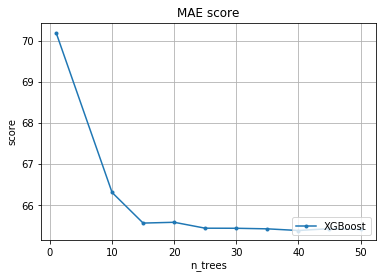

In [60]:
pylab.plot(n_trees, abs(xgb_scoring.mean(axis = 1)), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('MAE score')
pylab.legend(loc='lower right')

Как можно заметить, MAE уменьшается с возрастанием кол-ва деревьев до 10, а потом модель начинает переобучиваться и MAE возрастает, а средняя ошибка равна:

In [61]:
abs(xgb_scoring.mean())

66.02080672171272

In [62]:
estimator = xgb.XGBRFRegressor(learning_rate=1, n_estimators=10)

In [63]:
estimator.fit(X, y)
y_pred = estimator.predict(X)
y_test_pred = estimator.predict(X_test)

In [64]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.7152674206901584
mae_train 63.41093286282177
R2_test 0.6956536166266664
mae_test 65.98351085047304


In [65]:
MSE_History.append(['XGBoost', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

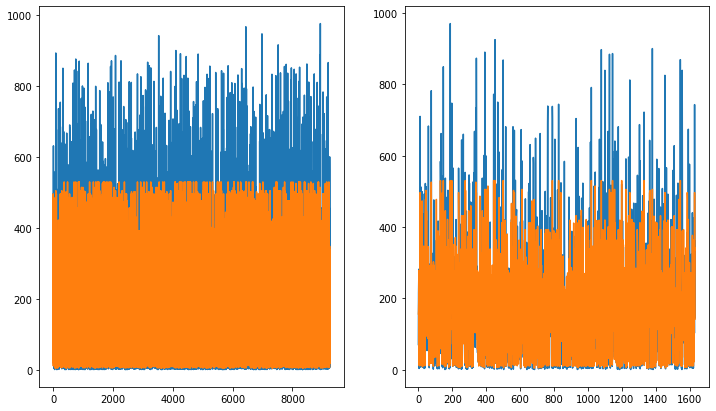

In [66]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

Тем не менее, алгоритм переобучается

## 8. PolynomialRegression

In [67]:
from sklearn.preprocessing import PolynomialFeatures

Возьмём полиномы второй и третьей степени:

In [68]:
for i in range(2,4):
    poly = PolynomialFeatures(degree = i)
    X_poly = poly.fit_transform(X)
    X_test_poly = poly.fit_transform(X_test)
    poly.fit(X_poly, y)
    lin2 = LinearRegression()
    lin2.fit(X_poly, y)
    y_pred = lin2.predict(X_poly)
    y_test_pred = lin2.predict(X_test_poly)
    print('mae_train', mean_absolute_error(y,y_pred))
    print('mae_test', mean_absolute_error(y_test,y_test_pred))

mae_train 95.27330789676321
mae_test 96.77677144729792
mae_train 83.41683053265456
mae_test 87.31210455196462


In [69]:
MSE_History.append(['PolynomialRegression', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

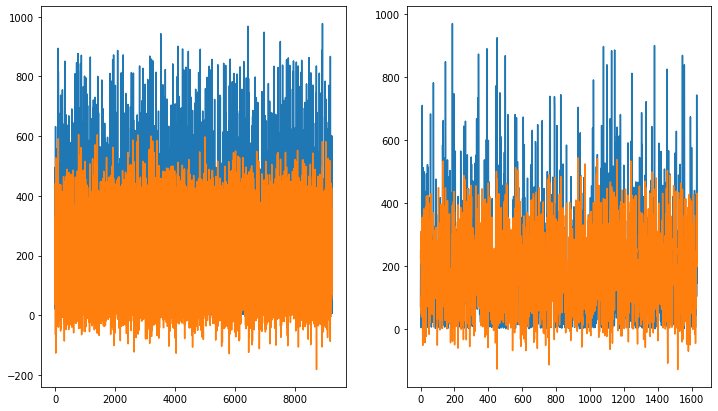

In [70]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

Видно, что полином третьей степени неплохо описывает зависимость

## 9. DecisionTree

In [71]:
from sklearn.tree import DecisionTreeRegressor

In [72]:
model = DecisionTreeRegressor(criterion = 'mae')

In [73]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [74]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 1.0
mae_train 0.0
R2_test 0.7538970198720769
mae_test 56.396203306797304


Можно заметить, что дерево переобучилось на обучающей выборке

In [75]:
model.get_depth()

33

Попробуем уменьшить глубину

In [76]:
model = DecisionTreeRegressor(criterion = 'mae', max_depth = 10)

In [77]:
model.fit(X, y)
y_pred = model.predict(X)
y_test_pred = model.predict(X_test)

In [78]:
print('R2_train', r2_score(y, y_pred))
print('mae_train', mean_absolute_error(y,y_pred))
print('R2_test', r2_score(y_test, y_test_pred))
print('mae_test', mean_absolute_error(y_test,y_test_pred))

R2_train 0.8484119426048664
mae_train 42.13703663676645
R2_test 0.7669553348599618
mae_test 55.501530924678505


In [79]:
MSE_History.append(['DecisionTree', mean_absolute_error(y,y_pred), mean_absolute_error(y_test,y_test_pred)])

Видно, что качество на обучающей выборке упало, модель стала искать паттерны, но это повлекло падение качества и на тестовой выборке (т.к. данных немного переобучение на обучающей выборке всё равно повышает качество на тренировочной выборке)

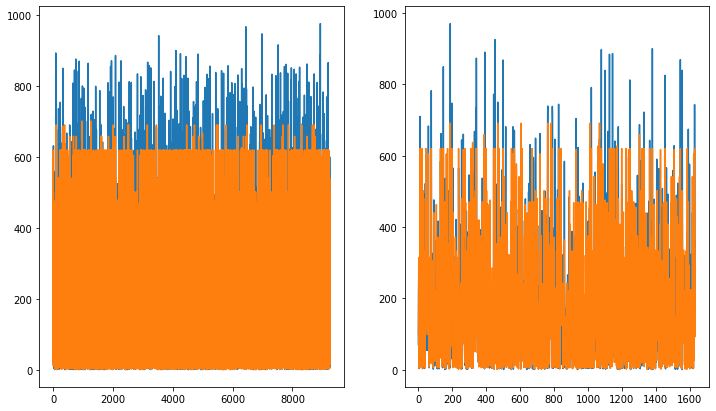

In [80]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y)
ax1.plot(y_pred)
ax2.plot(y_test)
ax2.plot(y_test_pred)

## 10. NeuralNetwork

Считаем данные заново и заново разделим на обучающую и тестовую выборки

In [81]:
raw_data = pd.read_csv('train.csv', header = 0, sep = ',')
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)
y = raw_data['count'].values
X = raw_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1).values

In [82]:
import torch
from torch import nn
from torch import functional as F

Нормализация фичей

In [83]:
X = ((X - X.mean(0))/X.std(0))

In [84]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# Превратим данные в тензоры
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

Объявим модель

In [85]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 100),
    nn.ReLU(),
    
    nn.Linear(100, 200),
    nn.ReLU(),
    
    nn.Linear(200, 100),
    nn.ReLU(),
    
    nn.Linear(100, 50),
    nn.ReLU(),
    
    nn.Linear(50, 1)
)
    
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Обучающий цикл

In [86]:
def train(X_train, y_train, X_test, y_test, num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        model.train(True)
        # Посчитаем предсказание и лосс
        y_pred = model(X_train)
        loss = loss_fn(y_pred, torch.reshape(y_train, (y_train.shape[0],1)))
        # зануляем градиент
        optimizer.zero_grad()

        # backward
        loss.backward()

        # ОБНОВЛЯЕМ веса
        optimizer.step()
        train_losses.append(loss.item())
        
        # Теперь посчитаем лосс на тесте
        model.train(False)
        with torch.no_grad():
            p_test = model(X_test)
            test_losses.append(loss_fn(p_test, torch.reshape(y_test, (y_test.shape[0],1))).item())
        print('Epoch: ', i+1, 'Loss: ', loss.item())       
    return train_losses, test_losses

In [87]:
train_losses, test_losses = train(X_train, y_train, X_test, y_test, 400)

Epoch:  1 Loss:  69402.3125
Epoch:  2 Loss:  69185.3671875
Epoch:  3 Loss:  68440.59375
Epoch:  4 Loss:  66503.1171875
Epoch:  5 Loss:  62407.88671875
Epoch:  6 Loss:  55131.78515625
Epoch:  7 Loss:  44433.55859375
Epoch:  8 Loss:  33378.53125
Epoch:  9 Loss:  33465.79296875
Epoch:  10 Loss:  37544.13671875
Epoch:  11 Loss:  30399.12109375
Epoch:  12 Loss:  24912.095703125
Epoch:  13 Loss:  24516.724609375
Epoch:  14 Loss:  25956.4453125
Epoch:  15 Loss:  26679.80078125
Epoch:  16 Loss:  26070.26953125
Epoch:  17 Loss:  24643.396484375
Epoch:  18 Loss:  23593.59765625
Epoch:  19 Loss:  24094.552734375
Epoch:  20 Loss:  25472.626953125
Epoch:  21 Loss:  25504.650390625
Epoch:  22 Loss:  24265.21484375
Epoch:  23 Loss:  23475.734375
Epoch:  24 Loss:  23632.671875
Epoch:  25 Loss:  24050.73828125
Epoch:  26 Loss:  24060.73828125
Epoch:  27 Loss:  23532.091796875
Epoch:  28 Loss:  22821.080078125
Epoch:  29 Loss:  22475.322265625
Epoch:  30 Loss:  22680.888671875
Epoch:  31 Loss:  22900.70

Epoch:  243 Loss:  5504.61474609375
Epoch:  244 Loss:  5594.783203125
Epoch:  245 Loss:  5201.2353515625
Epoch:  246 Loss:  5551.92822265625
Epoch:  247 Loss:  5094.6220703125
Epoch:  248 Loss:  5428.84130859375
Epoch:  249 Loss:  5001.18994140625
Epoch:  250 Loss:  5319.63623046875
Epoch:  251 Loss:  4953.91845703125
Epoch:  252 Loss:  5160.06298828125
Epoch:  253 Loss:  4933.4599609375
Epoch:  254 Loss:  5052.63134765625
Epoch:  255 Loss:  4868.4052734375
Epoch:  256 Loss:  4956.70263671875
Epoch:  257 Loss:  4829.59423828125
Epoch:  258 Loss:  4873.92724609375
Epoch:  259 Loss:  4766.93896484375
Epoch:  260 Loss:  4805.67138671875
Epoch:  261 Loss:  4716.244140625
Epoch:  262 Loss:  4750.583984375
Epoch:  263 Loss:  4652.4736328125
Epoch:  264 Loss:  4697.0498046875
Epoch:  265 Loss:  4603.13818359375
Epoch:  266 Loss:  4648.55078125
Epoch:  267 Loss:  4556.4296875
Epoch:  268 Loss:  4591.52001953125
Epoch:  269 Loss:  4517.34619140625
Epoch:  270 Loss:  4539.25341796875
Epoch:  271

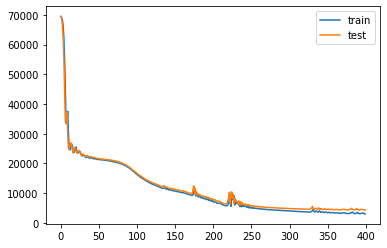

In [88]:
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()
plt.show()

Как мы видим, за 400 эпох сеть почти сошлась к своим оптимальным параметрам

In [89]:
model.eval()
train_pred_labels = model.forward(X_train)
test_pred_labels = model.forward(X_test)

In [90]:
print('mae_train',mean_absolute_error(train_pred_labels.detach().numpy(), y_train.numpy()))
print('mae_test', mean_absolute_error(test_pred_labels.detach().numpy(), y_test.numpy()))

mae_train 37.02709
mae_test 44.804466


In [91]:
MSE_History.append(['NeuralNetwork', mean_absolute_error(train_pred_labels.detach().numpy(), y_train.numpy()), mean_absolute_error(test_pred_labels.detach().numpy(), y_test.numpy())])

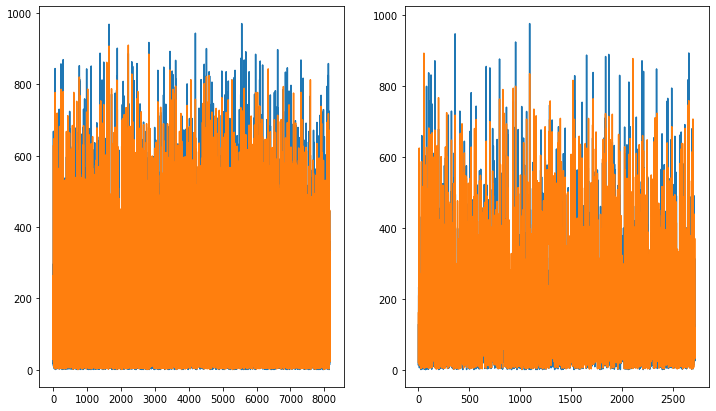

In [92]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(12, 7)
)
ax1.plot(y_train.numpy())
ax1.plot(train_pred_labels.detach().numpy())
ax2.plot(y_test.numpy())
ax2.plot(test_pred_labels.detach().numpy())

## Итоги

In [93]:
Algorithms = []
MSE_train = []
MSE_test = []

In [94]:
for i in MSE_History:
    Algorithms.append(i[0])
    MSE_train.append(i[1])
    MSE_test.append(i[2])

In [95]:
summary = pd.DataFrame(columns=['Algorithm', 'MSE_train', 'MSE_test'])
summary['Algorithm'] = Algorithms
summary['MSE_train'] = MSE_train
summary['MSE_test'] = MSE_test

In [96]:
summary

,Algorithm,MSE_train,MSE_test
0,LinearRegression,108.792204,108.998125
1,LinearRegression + Lasso,108.752093,108.976009
2,LinearRegression + Ridge,108.792127,108.998067
3,SVM,135.829614,137.275139
4,RandomForest,40.531746,50.319165
5,KNN,73.192771,87.261919
6,XGBoost,63.410933,65.983511
7,PolynomialRegression,83.416831,87.312105
8,DecisionTree,42.137037,55.501531
9,NeuralNetwork,37.027088,44.804466


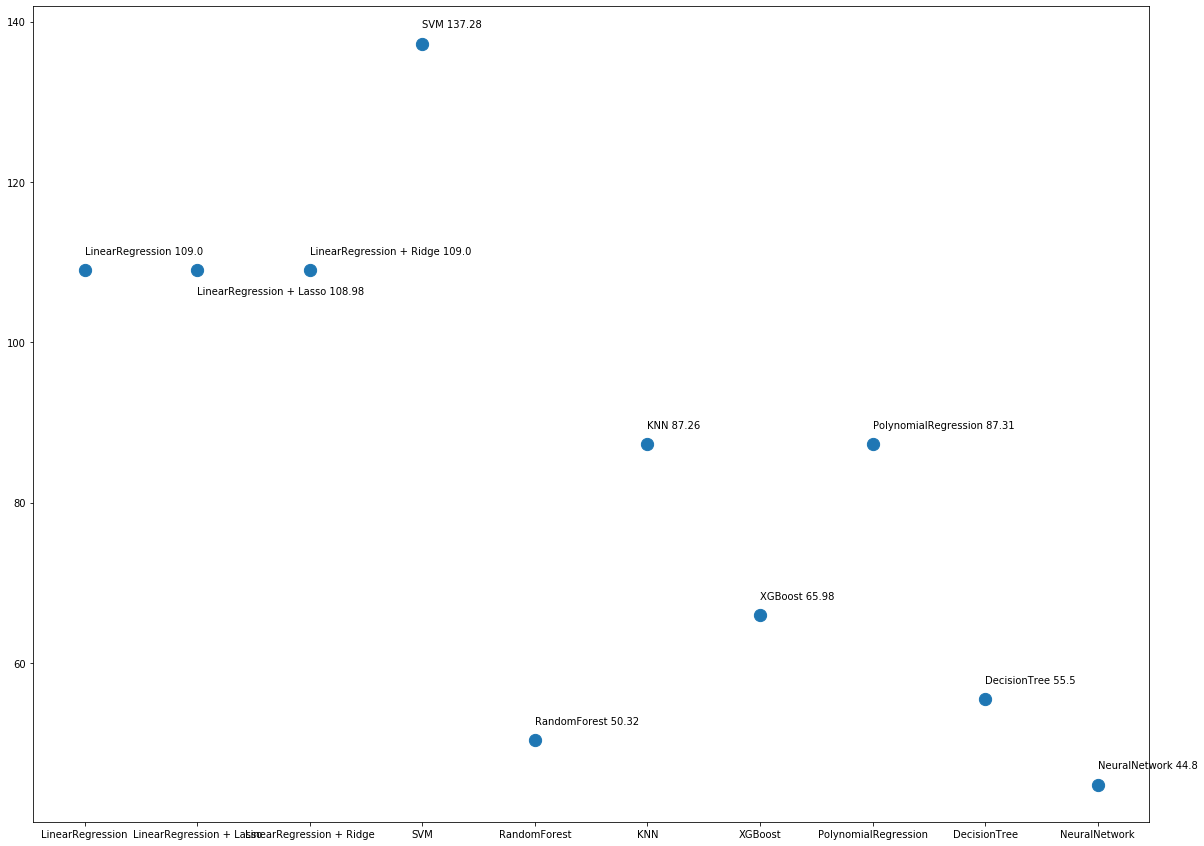

In [97]:
plt.figure(figsize=(20,15))
plt.scatter(summary.Algorithm, summary.MSE_test, marker='o', s = 150)
plt.annotate(summary['Algorithm'][0] + ' ' + str(round(summary['MSE_test'][0] ,2)), xy=(summary['Algorithm'][0], summary['MSE_test'][0] + 2))
plt.annotate(summary['Algorithm'][1] + ' ' + str(round(summary['MSE_test'][1] ,2)), xy=(summary['Algorithm'][1], summary['MSE_test'][1] - 3))
plt.annotate(summary['Algorithm'][2] + ' ' + str(round(summary['MSE_test'][2] ,2)), xy=(summary['Algorithm'][2], summary['MSE_test'][2] + 2))
for i in range(3,len(summary)):
    plt.annotate(summary['Algorithm'][i] + ' ' + str(round(summary['MSE_test'][i],2)), xy=(summary['Algorithm'][i], summary['MSE_test'][i] + 2))

Очевидно, что победителем по метрике качества MAE на тестовой выборке вышла нейронная сеть. Алгоритм RandomForest тоже достаточно неплохо себя показал, ансамбль деревьев XGBoost и его составляющая часть - DecisionTree совсем недалеко ушли. Полиномиальная регрессия расположилась на одном уровне с KNN, а семейство линейных регрессий, вне зависимости от регуляризатора, показали наихудшее качество, исключая SVM, на тестовой выборке